PHM Workbook

## Maintenance cost reduction through predictive techniques

In [1]:
#Misc
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import os
from numpy.random import seed
from numpy import argmax
from numpy import mean
import itertools
from math import *
from datetime import datetime
import time

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns 

#Preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import make_column_transformer
from sklearn.inspection import permutation_importance

#Models and metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn import metrics
from sklearn.metrics import f1_score, precision_recall_curve,auc,precision_recall_curve, confusion_matrix, classification_report

#Sampling
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.model_selection import cross_validate, TimeSeriesSplit,RepeatedStratifiedKFold


#Bayesian Optimzation
import skopt
from skopt import BayesSearchCV

np.random.seed(3)
cwd = os.getcwd()

In [64]:
#!pip install flaml[notebook]
import flaml

# Ultility Functions

In [3]:
#Breakdown target distribution
def target_breakdown(dataframe,target_variable):
    target_count = dataframe[target_variable].value_counts()
    print('Class 0:', target_count[0])
    print('Class 1:', target_count[1])
    print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')
    print('Unique Devices:', dataframe['device'].nunique())
    
#Plot correltaions        
def plot_correlations(df, drop_cols=[], title=''):
    tmp_df = df.drop(drop_cols, 1)
    corr = tmp_df.corr()
    plt.figure(figsize=(5, 5))
    g = sns.heatmap(corr)
    g.set_xticklabels(g.get_xticklabels(), rotation = 30, fontsize = 12)
    g.set_yticklabels(g.get_yticklabels(), rotation = 30, fontsize = 12)
    plt.title(title)
    plt.show()
    
#Plot all features by time   
def plot_all_measurements(df,x_axis,cols,title=''):
    fig, axs = plt.subplots(len(cols), figsize=(15,5))
    axs = axs.flatten()
    for i, col in enumerate(cols):
        axs[i].plot(x_axis, df[col], 'o')
        axs[i].invert_xaxis()
        h = axs[i].set_ylabel(col)
        h.set_rotation(0)
        axs[i].yaxis.set_label_position("right")
    plt.title(title)
    plt.show()

In [4]:
#Load data
df=pd.read_csv("aws_ds.csv")
#fi_df=pd.read_csv('feature_importances.csv')
#fi_df=pd.read_csv('feature_importances_ROBUST.csv')

#top features from feature selection
fi_df=pd.read_csv('feature_importances_XGBOOST_Normal.csv')

#Inspect data
df.sort_values(['device','date'],ascending=[True,True]).head()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,1/1/15,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,1/2/15,S1F01085,0,1650864,56,0,52,6,407438,0,0,7
2,1/3/15,S1F01085,0,124017368,56,0,52,6,407438,0,0,7
3,1/4/15,S1F01085,0,128073224,56,0,52,6,407439,0,0,7
4,1/5/15,S1F01085,0,97393448,56,0,52,6,408114,0,0,7


# Exploratory Data Analysis

In [5]:
#View column names, data types, and null count by column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65535 entries, 0 to 65534
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     65535 non-null  object
 1   device   65535 non-null  object
 2   failure  65535 non-null  int64 
 3   metric1  65535 non-null  int64 
 4   metric2  65535 non-null  int64 
 5   metric3  65535 non-null  int64 
 6   metric4  65535 non-null  int64 
 7   metric5  65535 non-null  int64 
 8   metric6  65535 non-null  int64 
 9   metric7  65535 non-null  int64 
 10  metric8  65535 non-null  int64 
 11  metric9  65535 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 6.0+ MB


In [6]:
# View Summary statistics of each variable
df.describe()

,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
count,65535.000000,6.553500e+04,65535.000000,65535.000000,65535.000000,65535.000000,65535.000000,65535.000000,65535.000000,65535.000000
mean,0.000778,1.225925e+08,134.220798,16.749920,1.235676,14.337453,273688.385855,0.258976,0.258976,16.524193
std,0.027886,7.032778e+07,2007.765985,255.145274,16.939779,16.466695,69804.573390,5.928018,5.928018,190.044701
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2.000000,25.000000,0.000000,0.000000,0.000000
25%,0.000000,6.176229e+07,0.000000,0.000000,0.000000,8.000000,226445.000000,0.000000,0.000000,0.000000
50%,0.000000,1.229175e+08,0.000000,0.000000,0.000000,10.000000,252413.000000,0.000000,0.000000,0.000000
75%,0.000000,1.833326e+08,0.000000,0.000000,0.000000,12.000000,306877.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64792.000000,24929.000000,1074.000000,98.000000,689161.000000,744.000000,744.000000,10137.000000


In [7]:
target_breakdown(df,'failure')

Class 0: 65484
Class 1: 51
Proportion: 1284.0 : 1
Unique Devices: 629


In [8]:
#Groupby device to determine total number of failures per device
df2=df[['device','failure']].groupby(by=['device'],as_index=False).sum()

#Filter records that were not failures
df2=df2[df2['failure']!=0]

#Create list of devices which experienced a failure and print how many unique devices there are
lt=df2['device'].unique()
print(len(lt))

#Filter orginal data set based on device list
df2=df[df['device'].isin(lt)]

#View summary statitics for devices that experienced failures
df2.describe()

51


,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
count,5283.000000,5.283000e+03,5283.000000,5283.000000,5283.000000,5283.000000,5283.000000,5283.000000,5283.000000,5283.000000
mean,0.009654,1.222155e+08,354.027636,0.058111,3.861064,17.667992,278438.948325,1.326519,1.326519,3.259512
std,0.097787,7.068491e+07,3764.790036,0.472083,22.177010,22.497472,65086.479978,15.392774,15.392774,55.517348
min,0.000000,1.592800e+04,0.000000,0.000000,0.000000,5.000000,39267.000000,0.000000,0.000000,0.000000
25%,0.000000,6.152042e+07,0.000000,0.000000,0.000000,8.000000,233613.500000,0.000000,0.000000,0.000000
50%,0.000000,1.223838e+08,0.000000,0.000000,0.000000,9.000000,264263.000000,0.000000,0.000000,0.000000
75%,0.000000,1.831286e+08,0.000000,0.000000,0.000000,14.000000,310064.500000,0.000000,0.000000,0.000000
max,1.000000,2.441357e+08,64776.000000,8.000000,841.000000,91.000000,574599.000000,744.000000,744.000000,1080.000000


Note: no record observed more than 1 failure and the total number of observations dropped from 65484 to 5283 and unique devices from 629 to 51.

In [9]:
target_breakdown(df2,'failure')

Class 0: 5232
Class 1: 51
Proportion: 102.59 : 1
Unique Devices: 51


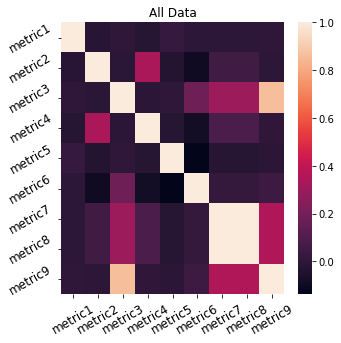

In [10]:
# plot correlations
plot_correlations(df2, drop_cols=['device', 'date', 'failure'],title='All Data')

Most metrics show minimal correlation amongst each other with the exception of mertic 3 and 9.

In [11]:
#del df #remove orginal data from memory and focus on devices which observed failures.

In [12]:
#Focus data on conditions leading up to failure to pick up a degraded signal
devices=df2['device'].unique()
df2['date']=pd.to_datetime(df2['date'])

df_rul=pd.DataFrame()
for device in devices:
    #isolate date of failures
    mask=((df2['failure']==1)&(df2['device']==device))
    failure_date=df2.loc[mask, 'date'].unique()
    #remove dates after failure occured
    test=df2[((df2['device']==device)&(df2['date']<=failure_date[0]))]
    df_rul=pd.concat([df_rul,test])
    
df2=df_rul #overwrite previous dataframe with filtered version for RUL creation
del df_rul

In two cases devices were repaired and continued to run after failure which prompted this revision

In [13]:
#Create Remaining Use Life Variable
df2['RUL']=1
df2=df2.sort_values(['device','date'],ascending=[True,False])
df2['RUL'] = df2.groupby(['device'])['RUL'].cumsum()
df2.reset_index(drop=True, inplace=True)
df2['diff'] = df2.groupby(['device'])['RUL'].diff()
df2=df2.sort_values(['device','date'],ascending=[True,True])
df2.head()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9,RUL,diff
18,2015-01-01,S1F023H2,0,141503600,0,0,1,19,494462,16,16,3,19,1.0
17,2015-01-02,S1F023H2,0,161679800,0,0,1,19,495730,16,16,3,18,1.0
16,2015-01-03,S1F023H2,0,182358672,0,0,1,19,496974,16,16,3,17,1.0
15,2015-01-04,S1F023H2,0,204752808,0,0,1,19,497559,16,16,3,16,1.0
14,2015-01-05,S1F023H2,0,226982888,0,0,1,19,498753,16,16,3,15,1.0


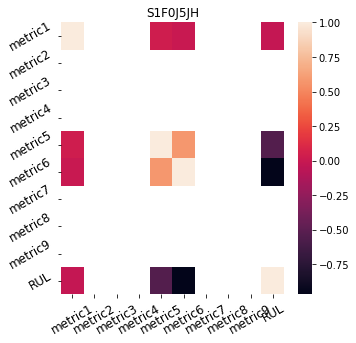

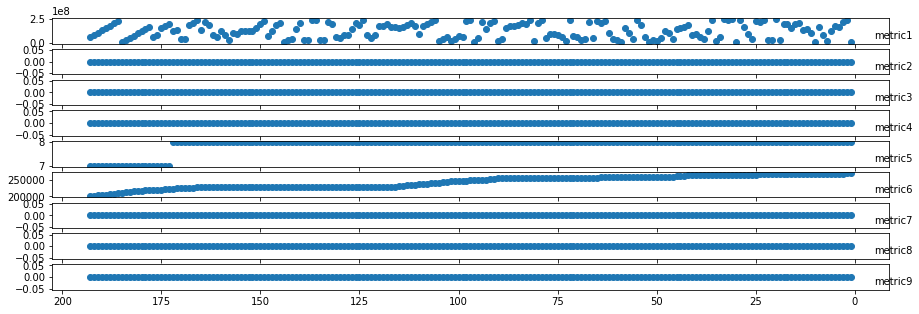

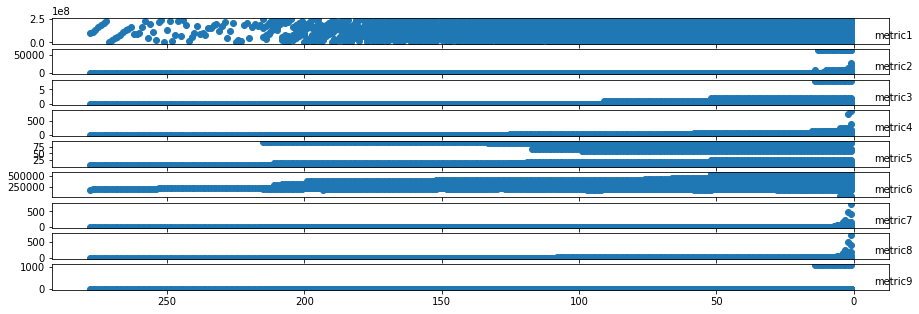

In [14]:
# plot correlations for device i
i = np.random.choice(df2.device)
dfp = df2.loc[df2.device==i].sort_values(by='date')
plot_correlations(dfp, drop_cols=['device', 'date', 'failure','diff'],title=i)
# plot of all features values by device
cols=['metric1', 'metric2', 'metric3', 'metric4',
       'metric5', 'metric6', 'metric7', 'metric8', 'metric9']
#Random Device Measurement
plot_all_measurements(dfp,dfp['RUL'],cols)
#All Measurements
plot_all_measurements(df2,df2['RUL'],cols)

Plotings metrics against RUL there is a clear uptick in readings as the device begins to degrade.

In [15]:
print(df2['diff'].unique()) #confirms that there are no gaps in data and imputation is not required
#remove diff
df2=df2.drop(columns=['diff'])

[ 1. nan]


# Feature Engineering

In [16]:
#After reviewing device ID's I noticed serveral potential patterns 
#which can potentially control for different device types and versions
#These would be questions I would ask a SME.

#list(df2['device'].unique())
df2['device type']=df2['device'].str[:3]
df2['device variant1']=df2['device'].str[3:4]
df2['device variant2']=df2['device'].str[3:5]

In [17]:
#Moving metric feature generation to capture time series dependence
columnsToFE = list(df2.select_dtypes(include=['int64']))
columnsToFE = list(np.setdiff1d(columnsToFE, ['failure','RUL']))
v1='device'
w=10
for i in columnsToFE: 
    df2['moving_mean_'+str(i)] = df2.groupby(v1).rolling(w,min_periods=1)[i].mean().reset_index(drop=True)
    df2['moving_max_'+str(i)] = df2.groupby(v1).rolling(w,min_periods=1)[i].max().reset_index(drop=True)
    df2['moving_min_'+str(i)] = df2.groupby(v1).rolling(w,min_periods=1)[i].min().reset_index(drop=True)
    df2['moving_std_'+str(i)] = df2.groupby(v1).rolling(w,min_periods=1)[i].std().reset_index(drop=True)
    
#fill std for last row with previous value
df2=df2.ffill(axis = 0)

In [18]:
#time of year Month,quarter, time of week (day sun-saturday),week of month

# Time features
df2['date']=pd.to_datetime(df2['date'])
df2['year'] = df2['date'].dt.year
df2['month'] = df2['date'].dt.month
df2['year']=df2['year'].astype(str)
df2['month']=df2['month'].astype(str)

#Sum failures by month
df2['month sum']=df2.groupby('month')['failure'].transform('sum')

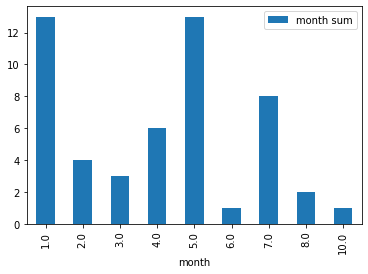

In [19]:
#Trend Analysis of number of failures by month
df3=df2[df2['failure']==1]
df4=df3.drop_duplicates(subset=['month'])
df4['month']=df4['month'].astype(float)
df4=df4.sort_values(['month'],ascending=[True])
ax = df4.plot.bar(x='month', y='month sum')

In [20]:
df3['device type'].value_counts()
# df3['device variant1'].value_counts()
# df3['device variant2'].value_counts()

S1F    42
W1F     9
Name: device type, dtype: int64

# Label construction for binary classification (determine optimal window to detect failures)

In [21]:
# Create new target for x days prior to failure event
df2['count'] =df2.groupby(['device'])['device'].transform("count")
x=list(np.arange(5,150,5))
eb_df2=pd.DataFrame()
for i in x:
    df3=df2[df2['count']>i]#.shape
    eb_df=pd.DataFrame({'X':[i],"Device":[df3['device'].nunique()],"Records":[len(df3)]})
    eb_df2=pd.concat([eb_df2,eb_df])

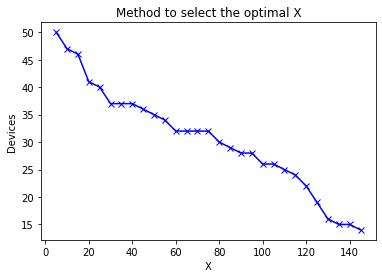

In [22]:
plt.plot(eb_df2['X'],eb_df2['Device'], 'bx-')
plt.xlabel('X')
plt.ylabel('Devices')
plt.title('Method to select the optimal X')
plt.show()

The above graph shows how dramatically devices begin to drop off as the window for detecting failure increases. This led to the selection of x to be 10 (Without having information regarding the supply chain this seems like a reasonable window to detect failure and schedule maintenance or order replacement devices). 

In [23]:
#Window for period of failure
x=10
#create new target variable with default vaules as previous target variable
df2['failure2']=df2['failure']
#replace new target variable with 1 in the remaining useful life was less than or equal to the specified window above
df2.loc[df2['RUL']<=x,'failure2']=1
df2.describe()

,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9,...,moving_max_metric8,moving_min_metric8,moving_std_metric8,moving_mean_metric9,moving_max_metric9,moving_min_metric9,moving_std_metric9,month sum,count,failure2
count,5266.000000,5.266000e+03,5266.000000,5266.000000,5266.000000,5266.000000,5266.000000,5266.000000,5266.000000,5266.000000,...,5266.000000,5266.000000,5266.000000,5266.000000,5266.000000,5266.000000,5266.000000,5266.000000,5266.00000,5266.000000
mean,0.009685,1.221450e+08,351.109761,0.058299,3.821876,17.696544,278431.961451,1.327763,1.327763,3.270034,...,1.417395,0.569692,0.328230,3.269180,3.270034,3.268325,0.000760,7.274972,153.12951,0.094189
std,0.097943,7.070254e+07,3765.716008,0.472833,22.091766,22.527826,65180.909238,15.416893,15.416893,55.606595,...,15.704661,2.975395,5.453402,55.606604,55.606595,55.606619,0.018645,4.521004,61.32643,0.292119
min,0.000000,1.592800e+04,0.000000,0.000000,0.000000,5.000000,39267.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.00000,0.000000
25%,0.000000,6.138793e+07,0.000000,0.000000,0.000000,8.000000,233057.250000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,117.00000,0.000000
50%,0.000000,1.222173e+08,0.000000,0.000000,0.000000,9.000000,264258.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,148.00000,0.000000
75%,0.000000,1.831068e+08,0.000000,0.000000,0.000000,14.000000,310066.750000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,201.00000,0.000000
max,1.000000,2.441357e+08,64776.000000,8.000000,841.000000,91.000000,574599.000000,744.000000,744.000000,1080.000000,...,744.000000,32.000000,265.331323,1080.000000,1080.000000,1080.000000,0.527046,13.000000,278.00000,1.000000


In [24]:
target_breakdown(df2,'failure2')

Class 0: 4770
Class 1: 496
Proportion: 9.62 : 1
Unique Devices: 51


By selecting a threshold of 10 days, 4 devices or ~7.84% of records are made up entirely of the positive class (26 records or ~0.49%)

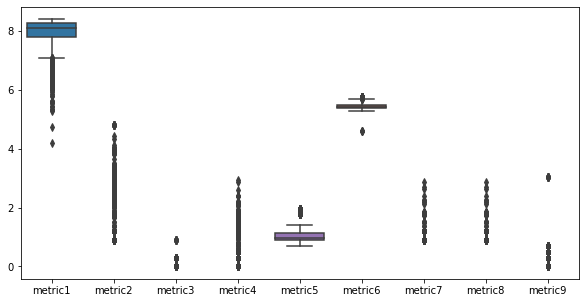

In [25]:
#boxplot to check for outliers
plt.figure(figsize=(10,5))
sns.boxplot(data=np.log10(df2[cols]))
plt.show()

Several metrics (1,5,6) contain outliers and would need to be scaled for alogrithms that are highly sensitive to them (e.g.K-Nearest Neighbor).

In [26]:
df2_ids = df2['device'].unique()

# How to split the data by device
train_share = 0.8
val_share = 0.1
test_share = 0.1


train_len = int(floor(len(df2_ids)*train_share))
test_len = int(floor(len(df2_ids)*test_share))

train_ids = np.random.choice(df2_ids, size=train_len, replace=False)
test_validate_ids = np.setdiff1d(df2_ids, train_ids)
test_ids = np.random.choice(test_validate_ids, size=test_len, replace=False)
validate_ids = np.setdiff1d(test_validate_ids, test_ids)

In [27]:
#Split and Save Data
train_all = df2.loc[df2['device'].isin(train_ids)]
validate_all = df2.loc[df2['device'].isin(validate_ids)]
test_all = df2.loc[df2['device'].isin(test_ids)]
train_all.reset_index(drop=True, inplace=True)
validate_all.reset_index(drop=True, inplace=True)
test_all.reset_index(drop=True, inplace=True)
    

train_all.to_csv(os.path.join(cwd, 'train.csv'), index=False)
validate_all.to_csv(os.path.join(cwd, 'validate.csv'), index=False)
test_all.to_csv(os.path.join(cwd, 'test.csv'), index=False)
df2.to_csv(os.path.join(cwd, 'df2.csv'), index=False)

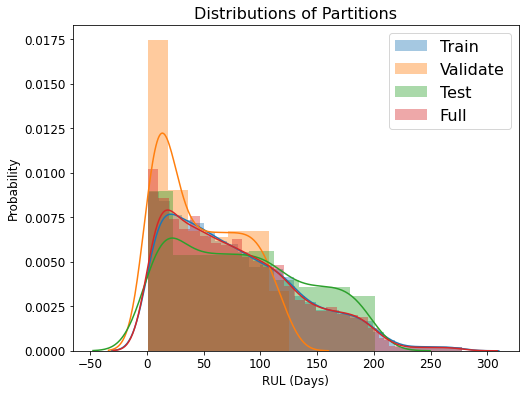

In [28]:
#Distribution plot of unscaled censored RUL values for each data set 
plt.figure(figsize=(8,6))
sns.distplot(train_all.RUL, label='Train')
sns.distplot(validate_all.RUL, label='Validate')
sns.distplot(test_all.RUL, label='Test')
sns.distplot(df2.RUL, label='Full')
plt.tick_params(axis='both', which='major', labelsize=12) 
plt.legend(fontsize=16)
plt.xlabel('RUL (Days)',fontsize=12)
plt.ylabel('Probability',fontsize=12)
plt.title('Distributions of Partitions',fontsize=16)
plt.show()

Here we see the breakdown of each distrbution for the partion of the full dataset. One point of interest is that the test set does not have any devices that had an RUL exceeding 200 days.

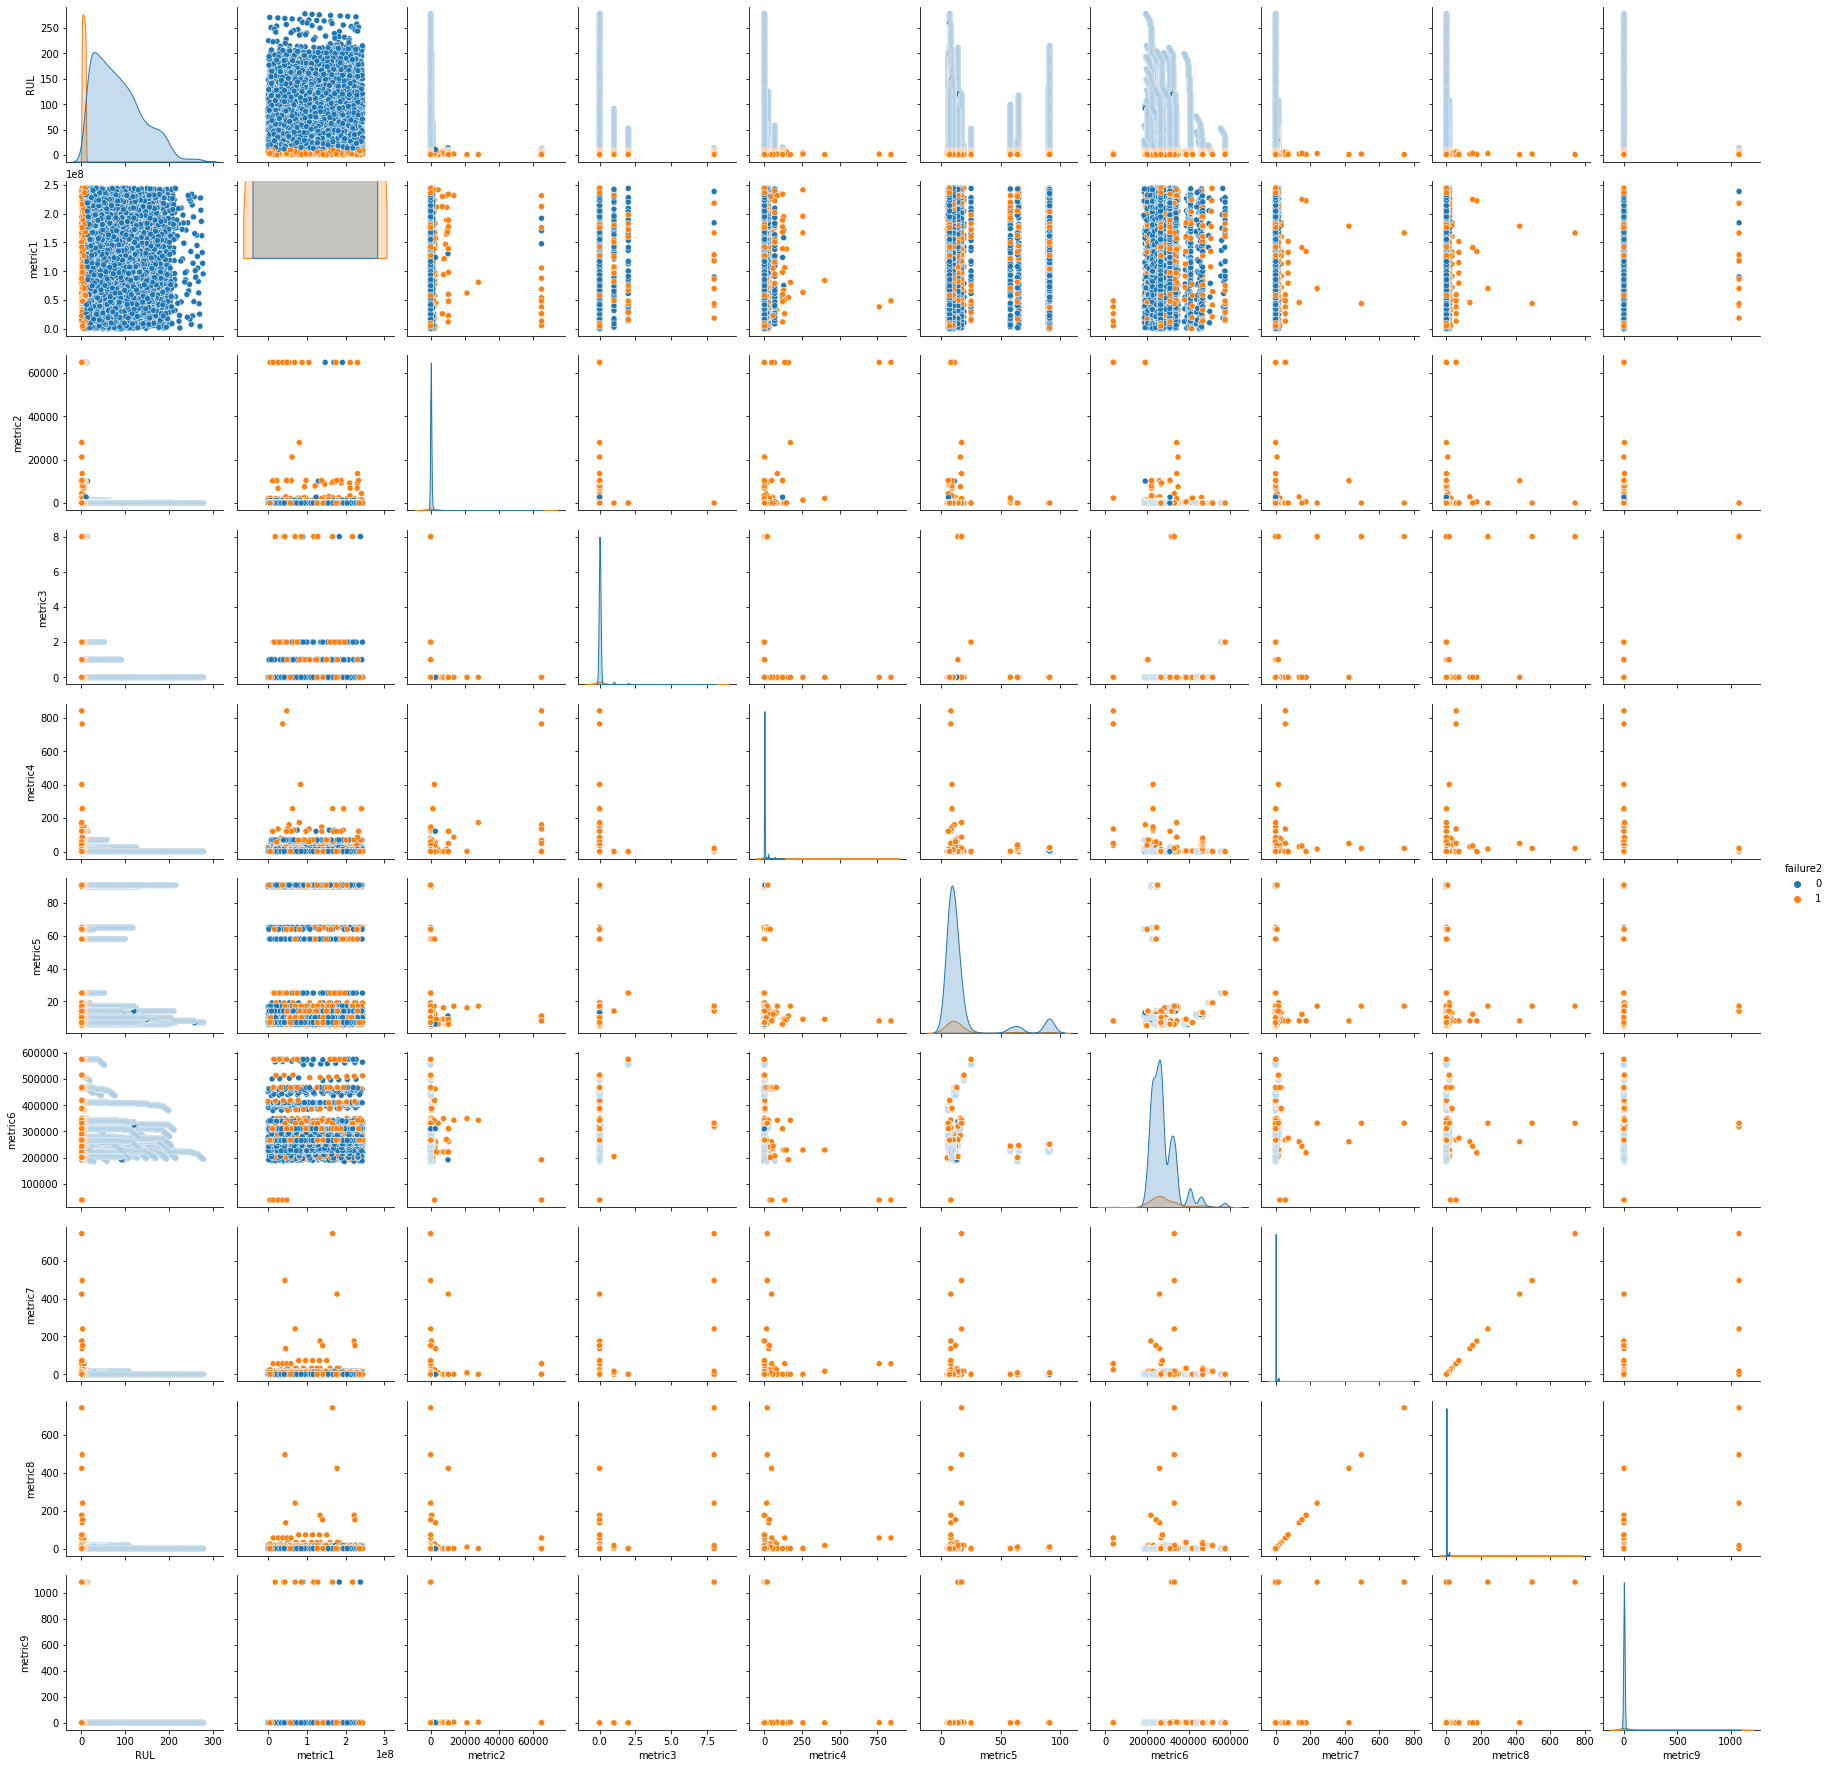

In [29]:
lt=['RUL','metric1', 'metric2', 'metric3', 'metric4',
       'metric5', 'metric6', 'metric7', 'metric8', 'metric9',"failure2"]
ax=sns.pairplot(df2[lt], hue="failure2", height=2.5)

- Blue denotes observations prior to the 10 day window while orange denotes observations in the failure horizon.
- One note is that many of the observations are orange, indicating they only appear in the later in more degraded devices (as shown in each metrics distribution).
- Only one strong correlation between Metric 7 and 8.

# Data Preprocessing

In [30]:
#Drop columns
train=train_all.drop(columns=['RUL','date','device','month sum','year','failure','count'])
validate=validate_all.drop(columns=['RUL','date','device','month sum','year','failure','count'])
test=test_all.drop(columns=['RUL','date','device','month sum','year','failure','count'])

In [31]:
#Separate Y (target) from X
columnsToEncode = list(train.select_dtypes(include=['category','object']))

y_train_df = train['failure2']
X_train_df = train.drop(columns=['failure2'])

y_validate_df = validate['failure2']
X_validate_df = validate.drop(columns=['failure2'])

y_test_df = test['failure2']
X_test_df = test.drop(columns=['failure2'])

In [32]:
#Transformers and Feature scaling
#col_transformer = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), columnsToEncode),remainder=StandardScaler())
col_transformer = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), columnsToEncode),remainder=MinMaxScaler())
#col_transformer = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), columnsToEncode),remainder=RobustScaler())

X = col_transformer.fit_transform(X_train_df)
Xv = col_transformer.transform(X_validate_df)
Xt = col_transformer.transform(X_test_df)

In [33]:
#Find Column Names of Encoded Columns
encoded_columns=list(pd.get_dummies(train[columnsToEncode]).columns)
new_columns = list(np.setdiff1d(X_train_df.columns,columnsToEncode))

In [34]:
new_columns=encoded_columns+new_columns
X_train=pd.DataFrame(data=X,columns=new_columns)
X_validate=pd.DataFrame(data=Xv,columns=new_columns)
X_test=pd.DataFrame(data=Xt,columns=new_columns)

# Model Training

In [50]:
#model = LogisticRegression()
#model = DecisionTreeClassifier()
#model = RandomForestClassifier()
#model = lgb.LGBMClassifier()
#model = XGBClassifier(seed=3)

params={'n_estimators': 485, 'max_leaves': 17, 'min_child_weight': 0.033429281512720004, 
        'learning_rate': 0.3522139416375615, 'subsample': 0.460715461678978, 
        'colsample_bylevel': 0.4249204700959838, 'colsample_bytree': 0.22696696016649986, 
        'reg_alpha': 0.046893085198196585, 'reg_lambda': 0.03805257069092993, 'max_depth':5}


model = XGBClassifier(**params,objective='binary:logistic',eval_metric='logloss',seed=3)
#ts standardized
#model=RandomForestClassifier(max_depth=39, max_features=3,min_samples_leaf=4, n_estimators=3650,random_state=3)

#normalized
#model=RandomForestClassifier(max_depth=29, max_features=5,min_samples_leaf=2, n_estimators=1512,random_state=3)

#robust
#model=RandomForestClassifier(max_depth=36, max_features=8,min_samples_leaf=7, n_estimators=1733,random_state=3)
#model=RandomForestClassifier(max_depth=15, max_features=6,min_samples_leaf=6, n_estimators=2197,random_state=3)


#feature selection
X_train=X_train[fi_df['Features'].unique()]
X_validate=X_validate[fi_df['Features'].unique()]
X_test=X_test[fi_df['Features'].unique()]

model.fit(X_train, y_train_df)
y_hat = model.predict(X_train)
y_hatv = model.predict(X_validate)
score = f1_score(y_validate_df, y_hatv, average='binary')
print('F-Score: %.5f' % score)
#F-Score: 0.74766 XGB with FS

F-Score: 0.73469


In [51]:
from sklearn import metrics

print(metrics.classification_report(y_train_df,y_hat,digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      4024
           1     1.0000    1.0000    1.0000       389

    accuracy                         1.0000      4413
   macro avg     1.0000    1.0000    1.0000      4413
weighted avg     1.0000    1.0000    1.0000      4413



In [ ]:
#Standard
# F-Score: 0.72727
# F-Score (Weighted): 0.90484

# F-Score: 0.73684
# F-Score (Weighted): 0.91019

# F-Score: 0.73913
# F-Score (Weighted): 0.91245

# F-Score: 0.74725
# F-Score (Weighted): 0.91565

#Normalized
# F-Score: 0.69663
# F-Score (Weighted): 0.89989

#Robust
# F-Score: 0.67857
# F-Score (Weighted): 0.87957

# F-Score: 0.61947
# F-Score (Weighted): 0.85666

# F-Score: 0.68421
# F-Score (Weighted): 0.88040

# F-Score: 0.72881
# F-Score (Weighted): 0.89505

# SMOTE

In [60]:
# values to evaluate
k_values = [1, 2, 3, 4, 5]
metrics=['f1','recall','precision']
for k in k_values:
    # define pipeline
    #model=RandomForestClassifier(max_depth=29, max_features=5,min_samples_leaf=2, n_estimators=1512,random_state=3)
    #model = XGBClassifier(seed=3)
    model = XGBClassifier(**params,objective='binary:logistic',eval_metric='logloss',seed=3)
    over = SMOTE(sampling_strategy=0.3, k_neighbors=k,random_state=3)
    under = RandomUnderSampler(sampling_strategy=0.5,random_state=3)
    steps = [('over', over), ('under', under), ('model', model)]
    pipeline = Pipeline(steps=steps)
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_validate(pipeline, X_train, y_train_df, scoring=metrics, cv=cv, n_jobs=-1)
    score = mean(scores['test_f1'])
    print('> k=%d, Mean Fscore: %.5f' % (k, score))

> k=1, Mean Fscore: 0.94644
> k=2, Mean Fscore: 0.94494
> k=3, Mean Fscore: 0.93960
> k=4, Mean Fscore: 0.94422
> k=5, Mean Fscore: 0.94214


In [61]:
over = SMOTE(sampling_strategy=0.3,k_neighbors=1, random_state=3)
under = RandomUnderSampler(sampling_strategy=0.5,random_state=3)
pipeline = Pipeline([('over', over), ('under', under), ('model', model)])
pipeline.fit(X_train, y_train_df) 

y_hat = pipeline.predict(X_train)
y_hatv = pipeline.predict(X_validate)
score = f1_score(y_train_df, y_hat, average='binary')
print('F-Score (Training): %.5f' % score)
score = f1_score(y_validate_df, y_hatv, average='binary')
print('F-Score (Validation): %.5f' % score)
#Normal
# F-Score: 0.68085

#Robust
#F-Score (Validation): 0.73600

F-Score (Training): 0.98731
F-Score (Validation): 0.69725


# Threshold Moving

f1=0.697 auc=0.776
Best Threshold=0.110768, F-Score=0.748


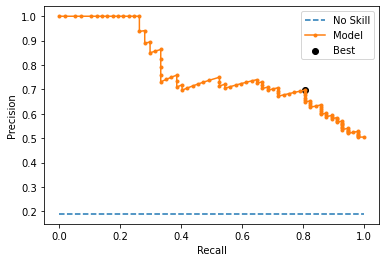

In [62]:
# precision-recall curve and f1
#y_hatv_pr = model.predict_proba(X_validate)
y_hatv_pr = pipeline.predict_proba(X_validate)

# keep probabilities for the positive outcome only
y_hatv_prob = y_hatv_pr[:, 1]
# calculate roc curves
precision, recall, thresholds = precision_recall_curve(y_validate_df, y_hatv_prob)

lr_f1, lr_auc = f1_score(y_validate_df, y_hatv), auc(recall, precision)
# summarize scores
print('f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
best_threshold=thresholds[ix]
# plot the roc curve for the model
no_skill = len(y_validate_df[y_validate_df==1]) / len(y_validate_df)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Model')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

# f1=0.748 auc=0.816
# Best Threshold=0.392016, F-Score=0.768

In [ ]:

#RF without MA
#Best Threshold=0.230000, F-Score=0.659

#RF without feature selection
#Best Threshold=0.160000, F-Score=0.742

#RF with feature selection iteration 1
#Best Threshold=0.170000, F-Score=0.741

#RF with feature selection iteration 2
#Best Threshold=0.420000, F-Score=0.757

#RF with feature selection iteration 3
#Best Threshold=0.750000, F-Score=0.725

#RF cv
#Best Threshold=0.183922, F-Score=0.756

#RF tscv
#Best Threshold=0.177260, F-Score=0.752
#Best Threshold=0.275003, F-Score=0.770 with tuning

# f1=0.727 auc=0.879
# Best Threshold=0.246717, F-Score=0.774

# f1=0.737 auc=0.880
# Best Threshold=0.237921, F-Score=0.758

# f1=0.747 auc=0.904
# Best Threshold=0.216379, F-Score=0.810


#Normal SMOTE
# f1=0.681 auc=0.822
# Best Threshold=0.189460, F-Score=0.704

#standard SMOTE
# f1=0.605 auc=0.831
# Best Threshold=0.340318, F-Score=0.741

# f1=0.760 auc=0.889
# Best Threshold=0.482889, F-Score=0.796

#Robust
# f1=0.736 auc=0.754
# Best Threshold=0.787814, F-Score=0.759

#Robust SMOTE
# f1=0.736 auc=0.754
# Best Threshold=0.787814, F-Score=0.759

Threshold moving maximizes F-1 score by varying the threshold of the classifier to predict the positive class (default threshold value is 0.5).

# Model Evaluation

In [53]:
from sklearn import metrics
print(metrics.classification_report(y_train_df,y_hat,digits=4)) # check overfitting

#Robust
#0.8390

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      4024
           1     1.0000    1.0000    1.0000       389

    accuracy                         1.0000      4413
   macro avg     1.0000    1.0000    1.0000      4413
weighted avg     1.0000    1.0000    1.0000      4413



F-Score: 0.69725
              precision    recall  f1-score   support

           0     0.9237    0.9426    0.9331       244
           1     0.7308    0.6667    0.6972        57

    accuracy                         0.8904       301
   macro avg     0.8272    0.8046    0.8152       301
weighted avg     0.8872    0.8904    0.8884       301



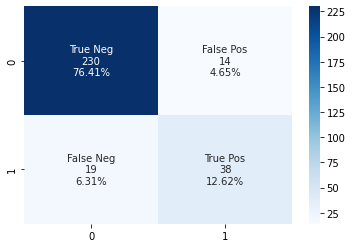

In [66]:
###### run classification report and confusion matrix

score = f1_score(y_validate_df,y_hatv, average='binary')
print('F-Score: %.5f' % score)

gbt_classification_report = metrics.classification_report(y_validate_df,y_hatv,digits=4)
print(gbt_classification_report)

#Create the basic matrix.
cf_matrix = confusion_matrix(y_validate_df,y_hatv)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax=sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

F-Score: 0.74797
              precision    recall  f1-score   support

           0     0.9532    0.9180    0.9353       244
           1     0.6970    0.8070    0.7480        57

    accuracy                         0.8970       301
   macro avg     0.8251    0.8625    0.8416       301
weighted avg     0.9047    0.8970    0.8998       301



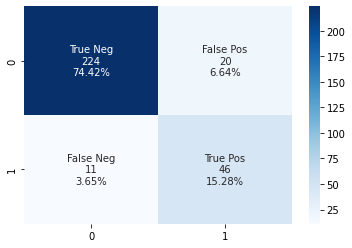

In [67]:
###### run classification report and confusion matrix for optimal threshold

results=pd.DataFrame({'Failure':y_validate_df,'Prediction':y_hatv,'Probability':y_hatv_pr[:, 1]})
results.loc[results['Probability']>=best_threshold,'Prediction']=1

gbt_classification_report = metrics.classification_report(results['Failure'],results['Prediction'],digits=4)

score = f1_score(y_validate_df,results['Prediction'], average='binary')
print('F-Score: %.5f' % score)
print(gbt_classification_report)

cf_matrix = confusion_matrix(results['Failure'],results['Prediction'])
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax=sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

Thresholding creates a more balanced classifier between errors of FP and FN. I would need more information regarding the cost of each to determine which model to deploy.

# Feature Selection

In [58]:
start_time = time.time()
result = permutation_importance(
    model, X_validate, y_validate_df, n_repeats=10, random_state=42, n_jobs=2)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=X_validate.columns)

Elapsed time to compute the importances: 0.719 seconds


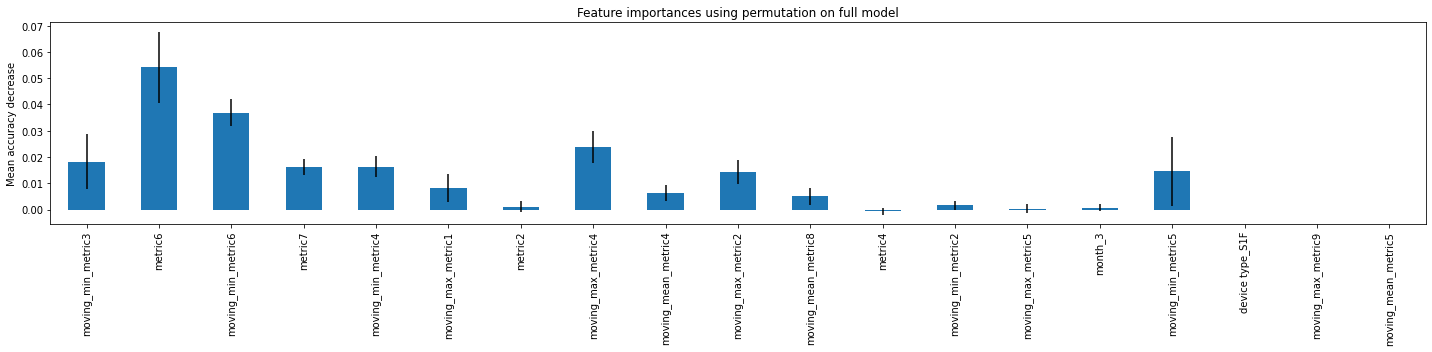

In [59]:
fig, ax = plt.subplots(figsize=(20,5))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

The computation for full permutation importance is more costly. Features are shuffled n times and the model refitted to estimate the importance of it. Values that are zero or negative were removed as they either add no value to the model or actually worsen model performance.

In [60]:
fi_df = pd.DataFrame({'Features':X_validate.columns,'MAD':result.importances_mean})
fi_df=fi_df[fi_df['MAD']>0]#reduce features to ones with predictive power (greater than zero)
fi_df=fi_df.sort_values('MAD',ascending=False)
print(fi_df.shape) #reduced features from 77 to 19 
#fi_df.to_csv('feature_importances_XGBOOST_Normal.csv',index=False)

(15, 2)


In [61]:
fi_df # final selected features form the leave one out permutation importance test.

,Features,MAD
1,metric6,0.054153
2,moving_min_metric6,0.036877
7,moving_max_metric4,0.023920
0,moving_min_metric3,0.018272
3,metric7,0.016279
4,moving_min_metric4,0.016279
15,moving_min_metric5,0.014618
9,moving_max_metric2,0.014286
5,moving_max_metric1,0.008306
8,moving_mean_metric4,0.006312


# Hyperparameter Tuning using Bayesian Optimization

In [1]:
#pip install -U scikit-learn=='0.23.2'
import sklearn
import skopt
from skopt import BayesSearchCV
import time
params={'n_estimators': (100,500), 'max_leaves': (5,20), 'min_child_weight': (0.001,0.05), 
        'learning_rate': (0.001,0.4), 'subsample': (0.2,0.85), 
        'colsample_bylevel': (0.2,0.6), 'colsample_bytree': (0.2,0.8), 
        'reg_alpha': (0.001,0.1), 'reg_lambda': (0.001,0.1), 'max_depth':(1,20),'objective':['binary:logistic'],'eval_metric' : ["logloss"]}

start=time.time()
cv = TimeSeriesSplit(n_splits=10)
searchcv = BayesSearchCV(XGBClassifier(seed=3),search_spaces=params,n_iter=10,cv=cv, scoring='f1')

# callback handler
def on_step(optim_result):
    score = searchcv.best_score_
    print("best score: %s" % score)
    print(searchcv.best_params_)
    if score >= 0.98:
        print('Interrupting!')
        return True
searchcv.fit(X_train,y_train_df, callback=on_step)
print("Validation score: %s" % searchcv.score(X_validate,y_validate_df))
print("--%s --Mins"%((time.time()-start)/60))

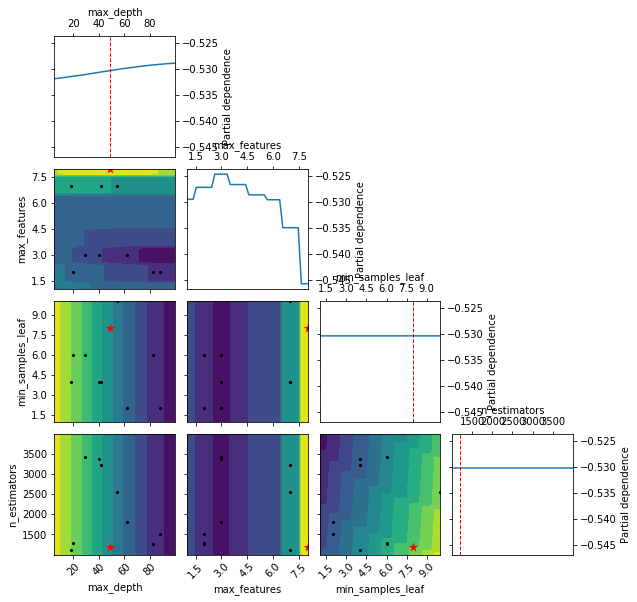

In [60]:
from skopt.plots import plot_objective

_ = plot_objective(searchcv.optimizer_results_[0],
                   dimensions=["max_depth", "max_features","min_samples_leaf", "n_estimators"],
                   n_minimum_search=int(1e8))
plt.show()

Shows observed minimum was found for each optimized feature (indicated by star and red line).

# Test Model

F-Score: 0.74747
auc=0.82984
F-Score(threshold): 0.83333
              precision    recall  f1-score   support

           0     0.9899    0.9741    0.9819       502
           1     0.7759    0.9000    0.8333        50

    accuracy                         0.9674       552
   macro avg     0.8829    0.9371    0.9076       552
weighted avg     0.9705    0.9674    0.9685       552



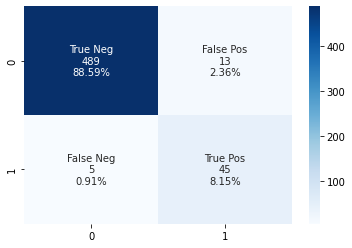

In [65]:
from sklearn import metrics
# y_hat_test=model.predict(X_test)
# y_hat_test_pr = model.predict_proba(X_test)

y_hat_test=pipeline.predict(X_test)
y_hat_test_pr = pipeline.predict_proba(X_test)

score = f1_score(y_test_df,y_hat_test, average='binary')
print('F-Score: %.5f' % score)

precision, recall, thresholds = precision_recall_curve(y_test_df, y_hat_test_pr[:, 1])

lr_auc = auc(recall, precision)
# summarize scores
print('auc=%.5f' % ( lr_auc))

###### run classification report and confusion matrix for optimal threshold

results=pd.DataFrame({'Failure':y_test_df,'Prediction':y_hat_test,'Probability':y_hat_test_pr[:, 1]})
#includes thresholding
results.loc[results['Probability']>=best_threshold,'Prediction']=1

score = f1_score(y_test_df,results['Prediction'], average='binary')
print('F-Score(threshold): %.5f' % score)

gbt_classification_report = metrics.classification_report(results['Failure'],results['Prediction'],digits=4)
print(gbt_classification_report)

cf_matrix = confusion_matrix(results['Failure'],results['Prediction'])
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax=sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')


#Standatd Scaler without smote and threshold
# F-Score: 0.65957
# auc=0.74636
# F-Score(threshold): 0.56552


#Normal Scaler with smote and without threshold
# F-Score: 0.74000
# auc=0.79568
# F-Score(threshold): 0.74000


#Robust
# F-Score: 0.67769
# auc=0.68032
# F-Score(threshold): 0.67769

In [ ]:
#standard
#Validation
# f1=0.747
#Test
#F-Score: 0.65957


#Normal SMOTE
#Validation
# f1=0.681
#Test
# F-Score: 0.74000

#Normal XG
#Validation
# F-Score: 0.73469
#Test
# F-Score: 0.79545

#Normal XG SMOTE
#validation threshold
#F-Score: 0.74797
#test
# F-Score: 0.74747
#F-Score(threshold): 0.83333

# Investigate where errors are occuring in device lifecylce to explore areas of refinement.

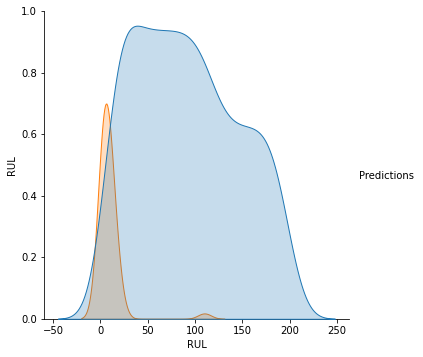

In [68]:
lt=['RUL','Predictions']
test_all['Predictions']=y_hat_test
ax=sns.pairplot(test_all[lt], hue="Predictions", height=5)

In [69]:
#False positive
mask=((test_all['RUL']>10) &(test_all['Predictions']!=0))
test_all_FP=test_all[mask]
test_all_FP['RUL'].value_counts().sort_index()

11     2
12     2
13     2
14     1
16     1
17     1
18     1
19     1
110    1
Name: RUL, dtype: int64

Errors from 19-11 seem to be not too costly as they provide earlier detection of failure and perhaps the system was showing early signs of degradation.

The other errors could be indicative of excessive operatings usage. Perhaps adding in a conditional check for consecutive days prior to confirming a near failure could eliminate some false positives and in this case elminate all false positives.

In [70]:
print(test_all['device'].nunique())
test_all_FP['device'].value_counts()

5


S1F023H2    8
S1F0GPFZ    3
S1F0GKFX    1
Name: device, dtype: int64

In [71]:
#Taking a look at quanitfying potential impact of failures
test_all_FP[['device','RUL']].groupby(['device']).mean()

,RUL
device,
S1F023H2,15
S1F0GKFX,110
S1F0GPFZ,12


In [72]:
#False Negative
mask=((test_all['Predictions']!=test_all['failure2'])&(test_all['failure2']==1))
test_all_FN=test_all[mask]
test_all_FN['RUL'].value_counts().sort_index()

2     1
5     1
7     2
8     3
9     3
10    3
Name: RUL, dtype: int64

In [73]:
print(test_all['device'].nunique())
test_all_FN['device'].value_counts()

5


W1F0F6BN    6
S1F0GKFX    4
S1F023H2    2
S1F0LD15    1
Name: device, dtype: int64

Overall, looking at the 4 devices with errors within 5 days of our window of 10 days.

After reviewing the results of the false negatives the majority are in the 7-10 day range. This evidence would suggest experimentation with various window sizes as well as exploring different feature egineering windows to optimize the isolation of the signals that are truly indicative of a device failure. Further testing and tuning is required on the training and validation set.

Other considerations: Although these signals were not indicative of an imminent failure perhaps it was indicative of excessive use and over a prolonged duration could have led to a failure. In practice,  I would go over these findings with a subject matter expert to see if we can work on improving the model or potentially influence operating conditions to prolong the life of the device. Also, we could add confidence to the model by creating an alert to where if there are consective days of failure prediction to intiate the process for repair/replacement.

# AutoML Pipeline

In [39]:
import sklearn
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from flaml import AutoML

set_config(display='diagram')

#col_transformer = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), columnsToEncode),remainder=StandardScaler())
col_transformer = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), columnsToEncode),remainder=MinMaxScaler())
#col_transformer = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), columnsToEncode),remainder=RobustScaler())
automl = AutoML()

automl_pipeline = Pipeline([
    ("column transformer",col_transformer),
    ("automl", automl)
])
automl_pipeline

Pipeline(steps=[('column transformer',
                 ColumnTransformer(remainder=MinMaxScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['device type',
                                                   'device variant1',
                                                   'device variant2',
                                                   'month'])])),
                ('automl', <flaml.automl.AutoML object at 0x7fd464b09ad0>)])

In [54]:
#!pip install -U scikit-learn=='0.24.2'
import sklearn
from sklearn import set_config
from sklearn.pipeline import Pipeline
import flaml
from flaml import AutoML

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.model_selection import cross_validate, TimeSeriesSplit,RepeatedStratifiedKFold

set_config(display='diagram')



over = SMOTE(sampling_strategy=0.3,k_neighbors=1, random_state=3)
under = RandomUnderSampler(sampling_strategy=0.5,random_state=3)
#col_transformer = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), columnsToEncode),remainder=StandardScaler())
#col_transformer = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), columnsToEncode),remainder=MinMaxScaler())
col_transformer = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), columnsToEncode),remainder=RobustScaler())
automl = AutoML()

automl_pipeline_SMOTE = Pipeline([
    ("column transformer",col_transformer),
    ('over', over), ('under', under),
    ("automl", automl)
])
automl_pipeline_SMOTE

Pipeline(steps=[('column transformer',
                 ColumnTransformer(remainder=RobustScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['device type',
                                                   'device variant1',
                                                   'device variant2',
                                                   'month'])])),
                ('over',
                 SMOTE(k_neighbors=1, random_state=3, sampling_strategy=0.3)),
                ('under',
                 RandomUnderSampler(random_state=3, sampling_strategy=0.5)),
                ('automl', <flaml.automl.AutoML object at 0x7f998f4d3ad0>)])

In [50]:
settings = {
    "time_budget": 600,  # total running time in seconds
    "metric": 'f1',  # primary metrics can be chosen from: ['accuracy','roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'f1','log_loss','mae','mse','r2']
    "task": 'classification',  # task type   
    "estimator_list":['xgboost','catboost','lgbm','rf'],
    "log_file_name": 'flaml.log',  # flaml log file
}

In [2]:
automl_pipeline.fit(X_train_df, y_train_df, 
                        automl__time_budget=settings['time_budget'],
                        automl__metric=settings['metric'],
                        automl__estimator_list=settings['estimator_list'],
                        automl__log_training_metric=True)

In [57]:
# Get the automl object from the pipeline
automl = automl_pipeline.steps[1][1]

# Get the best config and best learner
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best f-1 score on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

In [3]:
automl_pipeline_SMOTE.fit(X_train_df, y_train_df, 
                        automl__time_budget=settings['time_budget'],
                        automl__metric=settings['metric'],
                        automl__estimator_list=settings['estimator_list'],
                        automl__log_training_metric=True)

In [60]:
# Get the automl object from the pipeline
automl = automl_pipeline_SMOTE.steps[3][1]

# Get the best config and best learner
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best f-1 score on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 101, 'num_leaves': 68, 'min_child_samples': 2, 'learning_rate': 0.07144533523640893, 'log_max_bin': 7, 'colsample_bytree': 0.5661580857159144, 'reg_alpha': 0.01105951727305989, 'reg_lambda': 0.0011157179322807186}
Best f-1 score on validation data: 0.9926
Training duration of best run: 8.845 s


In [42]:
# Persist the automl object as pickle file
import pickle
with open('automl_SMOTE.pkl', 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)

In [61]:
from sklearn import metrics


y_hat = automl_pipeline_SMOTE.predict(X_train_df)
y_hatv = automl_pipeline_SMOTE.predict(X_validate_df)
score = f1_score(y_validate_df, y_hatv, average='binary')
print('F-Score: %.5f' % score)

F-Score: 0.69565


In [104]:
#col_transformer = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), columnsToEncode),remainder=StandardScaler())
col_transformer = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), columnsToEncode),remainder=MinMaxScaler())
#col_transformer = make_column_transformer((OneHotEncoder(handle_unknown="ignore"), columnsToEncode),remainder=RobustScaler())

params={'n_estimators': 116, 'max_leaves': 14, 'min_child_weight': 0.006657220422313735, 
        'learning_rate': 0.30391549904510595, 'subsample': 0.8125652004259216, 
        'colsample_bylevel': 0.4249204700959838, 'colsample_bytree': 0.5189481721748631, 
        'reg_alpha': 0.009487296541348228, 'reg_lambda': 0.004281487096906936, 'max_depth':4}
model_best = XGBClassifier(**params,seed=3)

automl_pipeline_refined = Pipeline([
    ("column transformer",col_transformer),
    ("automl", model_best)
])
automl_pipeline_refined

Pipeline(steps=[('column transformer',
                 ColumnTransformer(remainder=MinMaxScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['device type',
                                                   'device variant1',
                                                   'device variant2',
                                                   'month'])])),
                ('automl',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=0.4249204700959838,
                               colsample_bynode=None,
                               colsample_bytree=0.51894817...
                               max_delta_step=None, max_depth=4, max_leaves=14,
                               min_child_weight=0.006657220422313735,
                               missing=nan, monotone_constraints=None,
                               n_estimators=116, n_jobs=None,
                               num_parallel_tree=None, random_state=None,
                               reg_alpha=0.009487296541348228,
                               reg_lambda=0.004281487096906936,
                               scale_pos_weight=None, seed=3,
                               subsample=0.8125652004259216, tree_method=None,
                               validate_parameters=None, verbosity=None))])

In [106]:
automl_pipeline_refined.fit(X_train_df,y_train_df)

Pipeline(steps=[('column transformer',
                 ColumnTransformer(remainder=MinMaxScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['device type',
                                                   'device variant1',
                                                   'device variant2',
                                                   'month'])])),
                ('automl',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=0.4249204700959838,
                               colsample_bynode=1,
                               colsample_bytree=0.51894817...
                               max_delta_step=0, max_depth=4, max_leaves=14,
                               min_child_weight=0.006657220422313735,
                               missing=nan, monotone_constraints='()',
                               n_estimators=116, n_jobs=8, num_parallel_tree=1,
                               random_state=3, reg_alpha=0.009487296541348228,
                               reg_lambda=0.004281487096906936,
                               scale_pos_weight=1, seed=3,
                               subsample=0.8125652004259216,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

In [107]:
from sklearn import metrics


y_hat = automl_pipeline_refined.predict(X_train_df)
y_hatv = automl_pipeline_refined.predict(X_validate_df)
score = f1_score(y_validate_df, y_hatv, average='binary')
print('F-Score: %.5f' % score)

F-Score: 0.67961


In [53]:
from sklearn import metrics


y_hat = automl_pipeline.predict(X_train_df)
y_hatv = automl_pipeline.predict(X_validate_df)
score = f1_score(y_validate_df, y_hatv, average='binary')
print('F-Score: %.5f' % score)# increase from 0.62 to 0.68 to 0.73118

F-Score: 0.68966


In [62]:
print(metrics.classification_report(y_train_df,y_hat,digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.9973    0.9986      4024
           1     0.9725    1.0000    0.9861       389

    accuracy                         0.9975      4413
   macro avg     0.9863    0.9986    0.9923      4413
weighted avg     0.9976    0.9975    0.9975      4413



f1=0.696 auc=0.788
Best Threshold=0.015159, F-Score=0.743


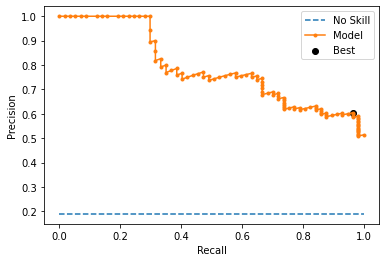

In [63]:
# precision-recall curve and f1
#y_hatv_pr = model.predict_proba(X_validate)
y_hatv_pr = automl_pipeline_SMOTE.predict_proba(X_validate_df)

# keep probabilities for the positive outcome only
y_hatv_prob = y_hatv_pr[:, 1]
# calculate roc curves
precision, recall, thresholds = precision_recall_curve(y_validate_df, y_hatv_prob)

lr_f1, lr_auc = f1_score(y_validate_df, y_hatv), auc(recall, precision)
# summarize scores
print('f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
best_threshold=thresholds[ix]
# plot the roc curve for the model
no_skill = len(y_validate_df[y_validate_df==1]) / len(y_validate_df)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Model')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

# f1=0.748 auc=0.816
# Best Threshold=0.392016, F-Score=0.768

F-Score: 0.81132
auc=0.84905
F-Score(threshold): 0.81132
              precision    recall  f1-score   support

           0     0.9859    0.9741    0.9800       502
           1     0.7679    0.8600    0.8113        50

    accuracy                         0.9638       552
   macro avg     0.8769    0.9171    0.8956       552
weighted avg     0.9661    0.9638    0.9647       552



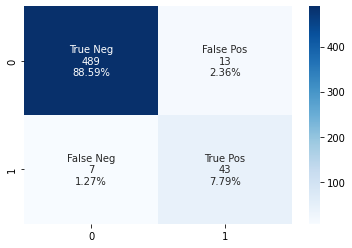

In [65]:
# y_hat_test=automl_pipeline.predict(X_test_df)
# y_hat_test_pr = automl_pipeline.predict_proba(X_test_df)

y_hat_test=automl_pipeline_SMOTE.predict(X_test_df)
y_hat_test_pr = automl_pipeline_SMOTE.predict_proba(X_test_df)

# y_hat_test=automl_pipeline_refined.predict(X_test_df)
# y_hat_test_pr = automl_pipeline_refined.predict_proba(X_test_df)


score = f1_score(y_test_df,y_hat_test, average='binary')
print('F-Score: %.5f' % score)

precision, recall, thresholds = precision_recall_curve(y_test_df, y_hat_test_pr[:, 1])

lr_auc = auc(recall, precision)
# summarize scores
print('auc=%.5f' % ( lr_auc))

###### run classification report and confusion matrix for optimal threshold
results=pd.DataFrame({'Failure':y_test_df,'Prediction':y_hat_test,'Probability':y_hat_test_pr[:, 1]})
#includes thresholding
#results.loc[results['Probability']>=best_threshold,'Prediction']=1

score = f1_score(y_test_df,results['Prediction'], average='binary')
print('F-Score(threshold): %.5f' % score)

gbt_classification_report = metrics.classification_report(results['Failure'],results['Prediction'],digits=4)
print(gbt_classification_report)

cf_matrix = confusion_matrix(results['Failure'],results['Prediction'])
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax=sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

# Future Considerations

- Compute RUL rather than probability
- Look at steady state of RUL with model to see where signal of degradation begins to occur.
- Further investifate errors and see where they are occuring during the lifecycle and potentially adjust window of prediction.
- Create more features based on various rolling windows.
- Experiment with other models and tune each (e.g. LSTMs,GRUs)
- Cross validate with grouped time series
- Fine tune smote and thresholding
- Quantify cost savings by detecting failures, FP and FN and compare to costs without

# Assumptions 
- Failure Horizon of 10 days (Window size)
- FN and FP are equally important